# Plot kinetic energy from ORCA12

Although everything works again in my old `py3_std` environment after fixing all the errors, I created a fresh environment during debugging. Using a fresh install gave me the latest dask and xarray, and the
```
msgpack/_packer.pyx in msgpack._cmsgpack.Packer._pack()

ValueError: memoryview is too large
```
error was gone. Save the file below into `~/eke.yaml`
```yaml
name: eke
channels:
  - conda-forge
dependencies:
  - cmocean
  - dask
  - distributed
  - ipython
  - ipykernel
  - matplotlib
  - numpy
  - xarray
  - netcdf4
  - h5netcdf
```
and run
```bash
source miniconda3/bin/activate base
conda env create -f ~/eke.yml
python -m ipykernel install --user --name eke --display-name "eke"
```

In [1]:
import numpy as np
import xarray as xr

In [2]:
import cmocean
from dask.distributed import Client, LocalCluster, wait

In [3]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [4]:
plt.style.use('dark_background')

In [5]:
cluster = LocalCluster(n_workers=8, threads_per_worker=2, memory_limit='16GB',
                       silence_logs=50)
client = Client(address=cluster)

In [6]:
client

Client Scheduler: tcp://127.0.0.1:40311 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 119.21 GiB


## Read mesh

In [7]:
ds_m = xr.open_dataset('/gxfs_work1/geomar/smomw352/mask_orca12.nc')
tmask = ds_m['tmask'][0,:,:,:]
ds_h = xr.open_dataset('/gxfs_work1/geomar/smomw352/mesh_hgr_orca12.nc')
e1t = ds_h['e1t'][0,:,:]
e2t = ds_h['e2t'][0,:,:]
areacello = e1t * e2t

In [65]:
ds_b = xr.open_dataset('/gxfs_work1/geomar/smomw352/bathymetry_ORCA12_V3.3.nc')
bathy = ds_b['Bathymetry']

In [8]:
def global_sfcmean(data):
    
    weights = (areacello * tmask[0,:,:]).fillna(0)
    weights.name = "weights"
    data_weighted = data.weighted(weights)
    weighted_mean = data_weighted.mean(("x", "y"))
    
    return weighted_mean

## Read data

I tried various chunking strategies (wasting hours :-( ), before finding out that the other options are a lot more important for the performance increase. All lat's and lon's in one chunk seem to be reasonable. 
I also renamed the dims as I think to remember that xarray does not like `nav_lon` and `nav_lat` as dim names, but that might be outdated information.

In [9]:
expnames = ['FOCI_BJK017','FOCI_BJK019']
times = [slice('1950-02-01','1952-12-31'),slice('1953-01-01','1959-12-31')]

The key change is to use `concat_dim='time_counter'` and `compat='override'`, see 
https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets for an explanation
Also the files from `FOCI_BJK019` seem to have have a second time dimension `time_centered` which caused problems later on when concatenating the two experiments.

In [10]:
u_5d_all = []
v_5d_all = []

for i, (exp,time) in enumerate( zip(expnames, times) ):
    
    # some files from 1959 are dead links, 
    # check gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo/
    time_str = '195[0-9]????_*' 
    chunks = {'x':None, 'y':None, 'deptht': 1, 'depthu':1, 'depthv':1, 'time_counter': 1} 
    #chunks = {'x':500, 'y':500, 'deptht': 1, 'depthu':1, 'depthv':1, 'time_counter': None}
    
    ddir = '/gxfs_work1/geomar/smomw352/esm-experiments/%s/outdata/nemo/' % (exp,)
    ufiles = '%s/%s_5d_%s_grid_U.nc' % (ddir,exp,time_str)
    print(ufiles)
    u_5d = xr.open_mfdataset(ufiles,combine='nested', 
                             concat_dim="time_counter", chunks=chunks,
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True).rename({'time_counter':'time', 'nav_lat':'lat', 'nav_lon':'lon', 'depthu':'deptht'}).sel(time=time)
    vfiles = '%s/%s_5d_%s_grid_V.nc' % (ddir,exp,time_str)
    print(vfiles)
    v_5d = xr.open_mfdataset(vfiles,combine='nested', 
                             concat_dim="time_counter", chunks=chunks,
                             data_vars='minimal', coords='minimal', compat='override', 
                             parallel=True).rename({'time_counter':'time', 'nav_lat':'lat', 'nav_lon':'lon', 'depthv':'deptht'}).sel(time=time)
    if exp == 'FOCI_BJK019': 
        u_5d_all.append(u_5d.drop('time_centered'))
        v_5d_all.append(v_5d.drop('time_centered'))
    else:
        u_5d_all.append(u_5d.drop('time_counter_bnds'))
        v_5d_all.append(v_5d.drop('time_counter_bnds'))
    

/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_195[0-9]????_*_grid_U.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK017/outdata/nemo//FOCI_BJK017_5d_195[0-9]????_*_grid_V.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_195[0-9]????_*_grid_U.nc
/gxfs_work1/geomar/smomw352/esm-experiments/FOCI_BJK019/outdata/nemo//FOCI_BJK019_5d_195[0-9]????_*_grid_V.nc


In [11]:
u_5d_all[0]

<xarray.Dataset>
Dimensions:      (time: 230, y: 3059, x: 4322, deptht: 75, bnds: 2)
Coordinates:
  * time         (time) datetime64[ns] 1950-02-03T12:00:00 ... 1952-12-31T12:...
    lon          (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
    lat          (y, x) float32 dask.array<chunksize=(3059, 4322), meta=np.ndarray>
  * deptht       (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: y, x, bnds
Data variables:
    depthu_bnds  (deptht, bnds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    uoce         (time, deptht, y, x) float32 dask.array<chunksize=(1, 1, 3059, 4322), meta=np.ndarray>
    utau         (time, y, x) float32 dask.array<chunksize=(1, 3059, 4322), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    name:                      FOCI_BJK017_1d_19500201_19500228_grid_U
    description:               ocean U grid variables
    title:                     ocean U grid variables
    timeStamp:                 2022-Jul-06 11:04:09 GMT
    uuid:                      4f42bf18-25fe-417a-923f-f0c663fd9a1e
    history:                   Fri Sep  2 15:03:19 2022: ncks -O -7 --no-alph...
    NCO:                       netCDF Operators version 4.9.3 (Homepage = htt...
    CDO:                       Climate Data Operators version 1.9.9 (https://...
    cdo_openmp_thread_number:  8

## Calculate kinetic energy, KE

Only for the surface!

$K_\mathrm{E} = \frac{1}{2} (u_s^2 + v_s^2)$

I added some calculations from the section below, see comments below why I did that.

In [12]:
ke_all = []
eke_all = []
for ds_u, ds_v in zip(u_5d_all, v_5d_all):
    _u = ds_u['uoce'].isel(deptht=0)
    _v = ds_v['voce'].isel(deptht=0) 
    #da_ke = (_u * _u + _v * _v) * 1/2.
    da_ke = (_u**2 + _v**2) * 1/2.
    ke_all.append(da_ke)
    
    run = 36 # 3x3 deg smoothing (1/12 * 36 = 3)
    # das muss oben in den loop
    um = _u.rolling(x=run,center=True).mean().rolling(y=run,center=True).mean()
    vm = _v.rolling(x=run,center=True).mean().rolling(y=run,center=True).mean()
    #
    ue = (_u - um)
    ve = (_v - vm)
    
    #ue = _u.groupby('time.year') - _u.groupby('time.year').mean('time')
    #ve = _v.groupby('time.year') - _v.groupby('time.year').mean('time')
    
    eke = (ue*ue + ve*ve) * 1/2.
    eke_all.append(eke)
    

In [13]:
ke_all

[<xarray.DataArray (time: 230, y: 3059, x: 4322)>
 dask.array<truediv, shape=(230, 3059, 4322), dtype=float32, chunksize=(1, 3059, 4322), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 1950-02-03T12:00:00 ... 1952-12-31T12:00:00
     deptht   float32 0.5058
 Dimensions without coordinates: y, x,
 <xarray.DataArray (time: 497, y: 3059, x: 4322)>
 dask.array<truediv, shape=(497, 3059, 4322), dtype=float32, chunksize=(1, 3059, 4322), chunktype=numpy.ndarray>
 Coordinates:
     deptht   float32 0.5058
   * time     (time) datetime64[ns] 1953-01-03T12:00:00 ... 1959-12-28T12:00:00
 Dimensions without coordinates: y, x]

In [14]:
eke_all

[<xarray.DataArray (time: 230, y: 3059, x: 4322)>
 dask.array<truediv, shape=(230, 3059, 4322), dtype=float64, chunksize=(1, 3058, 4321), chunktype=numpy.ndarray>
 Coordinates:
   * time     (time) datetime64[ns] 1950-02-03T12:00:00 ... 1952-12-31T12:00:00
     deptht   float32 0.5058
 Dimensions without coordinates: y, x,
 <xarray.DataArray (time: 497, y: 3059, x: 4322)>
 dask.array<truediv, shape=(497, 3059, 4322), dtype=float64, chunksize=(1, 3058, 4321), chunktype=numpy.ndarray>
 Coordinates:
     deptht   float32 0.5058
   * time     (time) datetime64[ns] 1953-01-03T12:00:00 ... 1959-12-28T12:00:00
 Dimensions without coordinates: y, x]

## Split to mean and eddy KE 
IMO, this code is probably not what you want as e.g. `ds_u['uoce']` only contains the data from the second experiment.
I hence added it to the loop above

In [15]:
#run = 36 # 3x3 deg smoothing (1/12 * 36 = 3)
# das muss oben in den loop
#um = ds_u['uoce'].isel(deptht=0).rolling(x=run,center=True).mean().rolling(y=run,center=True).mean()
#vm = ds_v['voce'].isel(deptht=0).rolling(x=run,center=True).mean().rolling(y=run,center=True).mean()

In [16]:
#ue = (ds_u['uoce'].isel(deptht=0) - um)
#ve = (ds_v['voce'].isel(deptht=0) - vm)

In [17]:
#eke = (ue*ue + ve*ve) * 1/2.

### Some debug plots

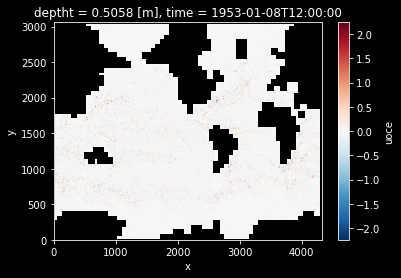

In [15]:
ue[1,:,:].plot()

In [ ]:
z = eke[-1,:,:].compute()
zl = xr.ufuncs.log(z)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
#tmask[0,:,:].where(tmask[0,:,:] > 0.5).plot.contourf(ax=ax, levels=[0,0.5], cmap=plt.cm.Greys_r, add_colorbar=False)
#z[1500:2500,2500:3000].plot(ax=ax, vmin=0, vmax=0.5, rasterized=True, cmap=cmocean.cm.amp)
#tmask[0,1500:2500,2500:3000].plot.contour(ax=ax, levels=[0], colors='k')
(z/z * bathy).plot(ax=ax, cmap=cmocean.cm.deep, vmin=0, vmax=6000, rasterized=True)
fig.savefig('figures/elpin.pdf',format='pdf',dpi=150)

## Global mean KE

In [20]:
ke_mean_all = []
for da_ke in ke_all:
    ke_mean = global_sfcmean(da_ke).compute()
    ke_mean_all.append(ke_mean)

In [21]:
ke = xr.concat(ke_mean_all, dim='time')

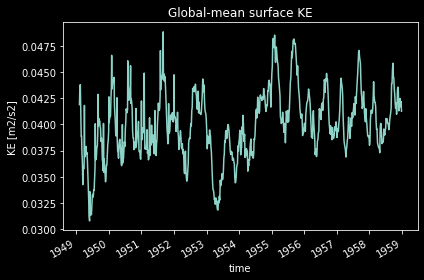

In [22]:
fig1, ax1 = plt.subplots(1,1)

ke.plot(ax=ax1)
ax1.set_title('Global-mean surface KE')
ax1.set_ylabel('KE [m2/s2]')
fig1.tight_layout()

In [23]:
eke_mean_all = []
for da_eke in eke_all:
    eke_mean = global_sfcmean(da_eke)
    eke_mean_all.append(eke_mean)

In [24]:
eke = xr.concat(eke_mean_all, dim='time')

In [ ]:
eke.compute()

In [ ]:
fig1, ax1 = plt.subplots(1,1)

eke.plot(ax=ax1)
ax1.set_title('Global-mean surface EKE (annual mean subtracted)')
ax1.set_ylabel('KE [m2/s2]')
fig1.tight_layout()
fig1.savefig('figures/EKE_mean.pdf',format='pdf')